## RandomForest only use and evaluation


In [1]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 73.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import koreanize_matplotlib


In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/모델링데이터/df_1_label.csv"
df = pd.read_csv(path)
df.head()

,보증금만원,계약분기,건축년도,계약연도,계약개월수,층,전용면적m,계약구분보완(범주),거래량,갱신요구권사용(2진),종전계약유무(2진),구_단지별_이상치만원(2진),클러스터,지하철_거리(m),초등학교 거리(미터),Index,Rate,PpRate,보증금면적비
0,38000.0,2,2004,2019,24,18,59.700,1,86,0,0,0,16,386.605843,342.200105,2203.59,1.75,5.285769,636.515913
1,51500.0,2,2000,2019,24,12,84.710,1,373,0,0,0,29,331.830814,451.914304,2203.59,1.75,5.285769,607.956558
2,47000.0,2,2000,2019,24,2,84.870,1,509,0,0,0,18,201.533731,357.832334,2203.59,1.75,5.285769,553.788147
3,70000.0,2,2017,2019,24,8,84.614,1,107,0,0,0,9,566.332822,231.623284,2203.59,1.75,5.285769,827.286265
4,70000.0,2,2017,2019,24,6,84.836,1,106,0,0,0,14,566.332822,231.623284,2203.59,1.75,5.285769,825.121411


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ✅ Feature & Target 설정
li = ["전용면적m", "보증금면적비", "클러스터", "건축년도", "층", "거래량", "지하철_거리(m)", "초등학교 거리(미터)", "계약연도", "Index"]
X = df[li]  # "보증금만원"이 Target 변수

y = df["보증금만원"]

# ✅ 학습 데이터 & 테스트 데이터 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📌 학습 데이터 크기: {X_train.shape}, 테스트 데이터 크기: {X_test.shape}")

📌 학습 데이터 크기: (718442, 10), 테스트 데이터 크기: (179611, 10)


## 랜덤포레스트 하이퍼 파라미터 설정 모델: `rf_model`
- `n_estimators=300`,  # 트리 개수
- `max_depth=15`,  # 트리 깊이 제한
- `min_samples_split=5`,  # 노드 분할 최소 샘플 개수
- `min_samples_leaf=2`,  # 리프 노드 최소 샘플 개수
- `max_features= 7`,  # 사용할 Feature 개수 통상적으로 회귀 모델에서는 `Feature/3`
-` random_state=42`

In [6]:
# ✅ 랜덤포레스트 모델 생성
rf_model = RandomForestRegressor(
    n_estimators=500,  # 트리 개수
    max_depth=18,  # 트리 깊이 제한
    min_samples_split=10,  # 노드 분할 최소 샘플 개수
    min_samples_leaf=2,  # 리프 노드 최소 샘플 개수
    max_features= 5,  # 사용할 Feature 개수
    random_state=42,
)

# ✅ 모델 학습
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=18, max_features=5, min_samples_leaf=2,
                      min_samples_split=10, n_estimators=500, random_state=42)

In [7]:
# TEST data
y_pred_rf = rf_model.predict(X_test)

# 성능 평가
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))


In [8]:
print(f"[랜덤포레스트 모델] \n 트리 개수: 500\n 트리 깊이 제한=18 \n 노드 분할 최소 샘플 개수: 10 \n 리프 노드 최소 샘플 개수: 2 \n 속성 제한: 5 \n random_state: 42 \n \n MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")

[랜덤포레스트 모델] 
 트리 개수: 500
 트리 깊이 제한=18 
 노드 분할 최소 샘플 개수: 10 
 리프 노드 최소 샘플 개수: 2 
 속성 제한: 5 
 random_state: 42 
 
 MAE: 117.13, RMSE: 323.14


In [9]:
residuals = y_test - y_pred_rf

# 결과 탐색

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

def analyze_residual_distribution(model_name, y_test, y_pred, dpi=500):
    """
    모델의 잔차/실제값 비율을 분석하여 KDE 그래프 & QQ-Plot을 고화질(DPI 설정)로 생성하는 함수.

    Parameters:
    - model_name: 모델 이름 (str) (예: "RandomForest_1", "XGBoost_2")
    - y_test: 실제값 (numpy array 또는 pandas Series)
    - y_pred: 예측값 (numpy array 또는 pandas Series)
    - dpi: 그래프 해상도 설정 (기본값: 500)

    Returns:
    - relative_residual: 잔차/실제값 비율 (numpy array)
    """
    # ✅ 잔차 및 상대 오차 계산
    residuals = y_test - y_pred
    relative_residual = (residuals / (y_test + 1e+02)) * 100  # 퍼센트 변환 (실제값 기준)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=dpi)  # ✅ 고화질 설정

    # ✅ KDE(커널 밀도) 그래프
    sns.kdeplot(relative_residual, fill=True, color="purple", alpha=0.6, ax=axes[0])
    axes[0].axvline(0, color="black", linestyle="--")  # 0 기준선 추가
    axes[0].set_xlabel("Relative Residual [(Residuals / Observed Values) × 100]", fontsize=14)
    axes[0].set_ylabel("Density", fontsize=14)
    axes[0].set_title(f"KDE Plot of Relative Residual (%) ({model_name})", fontsize=16, fontweight='bold')
    axes[0].grid(axis='x', linestyle="--", alpha=0.7)

    # ✅ QQ-Plot (표준화된 잔차 사용)
    standardized_residuals = (residuals - np.mean(residuals)) / (np.std(residuals) + 1e-10)  # 표준화된 잔차
    stats.probplot(standardized_residuals, dist="norm", plot=axes[1])
    axes[1].set_title(f"QQ Plot of Standardized Residuals ({model_name})", fontsize=16, fontweight='bold')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return relative_residual

# ✅ 사용 예제 (모델별 실행)
# relative_residual_rf = analyze_residual_distribution("RandomForest", y_test, y_pred_rf)
# relative_residual_xgb = analyze_residual_distribution("XGBoost", y_test, y_pred_xgb)

## 잔차비를 퍼센트로 전환

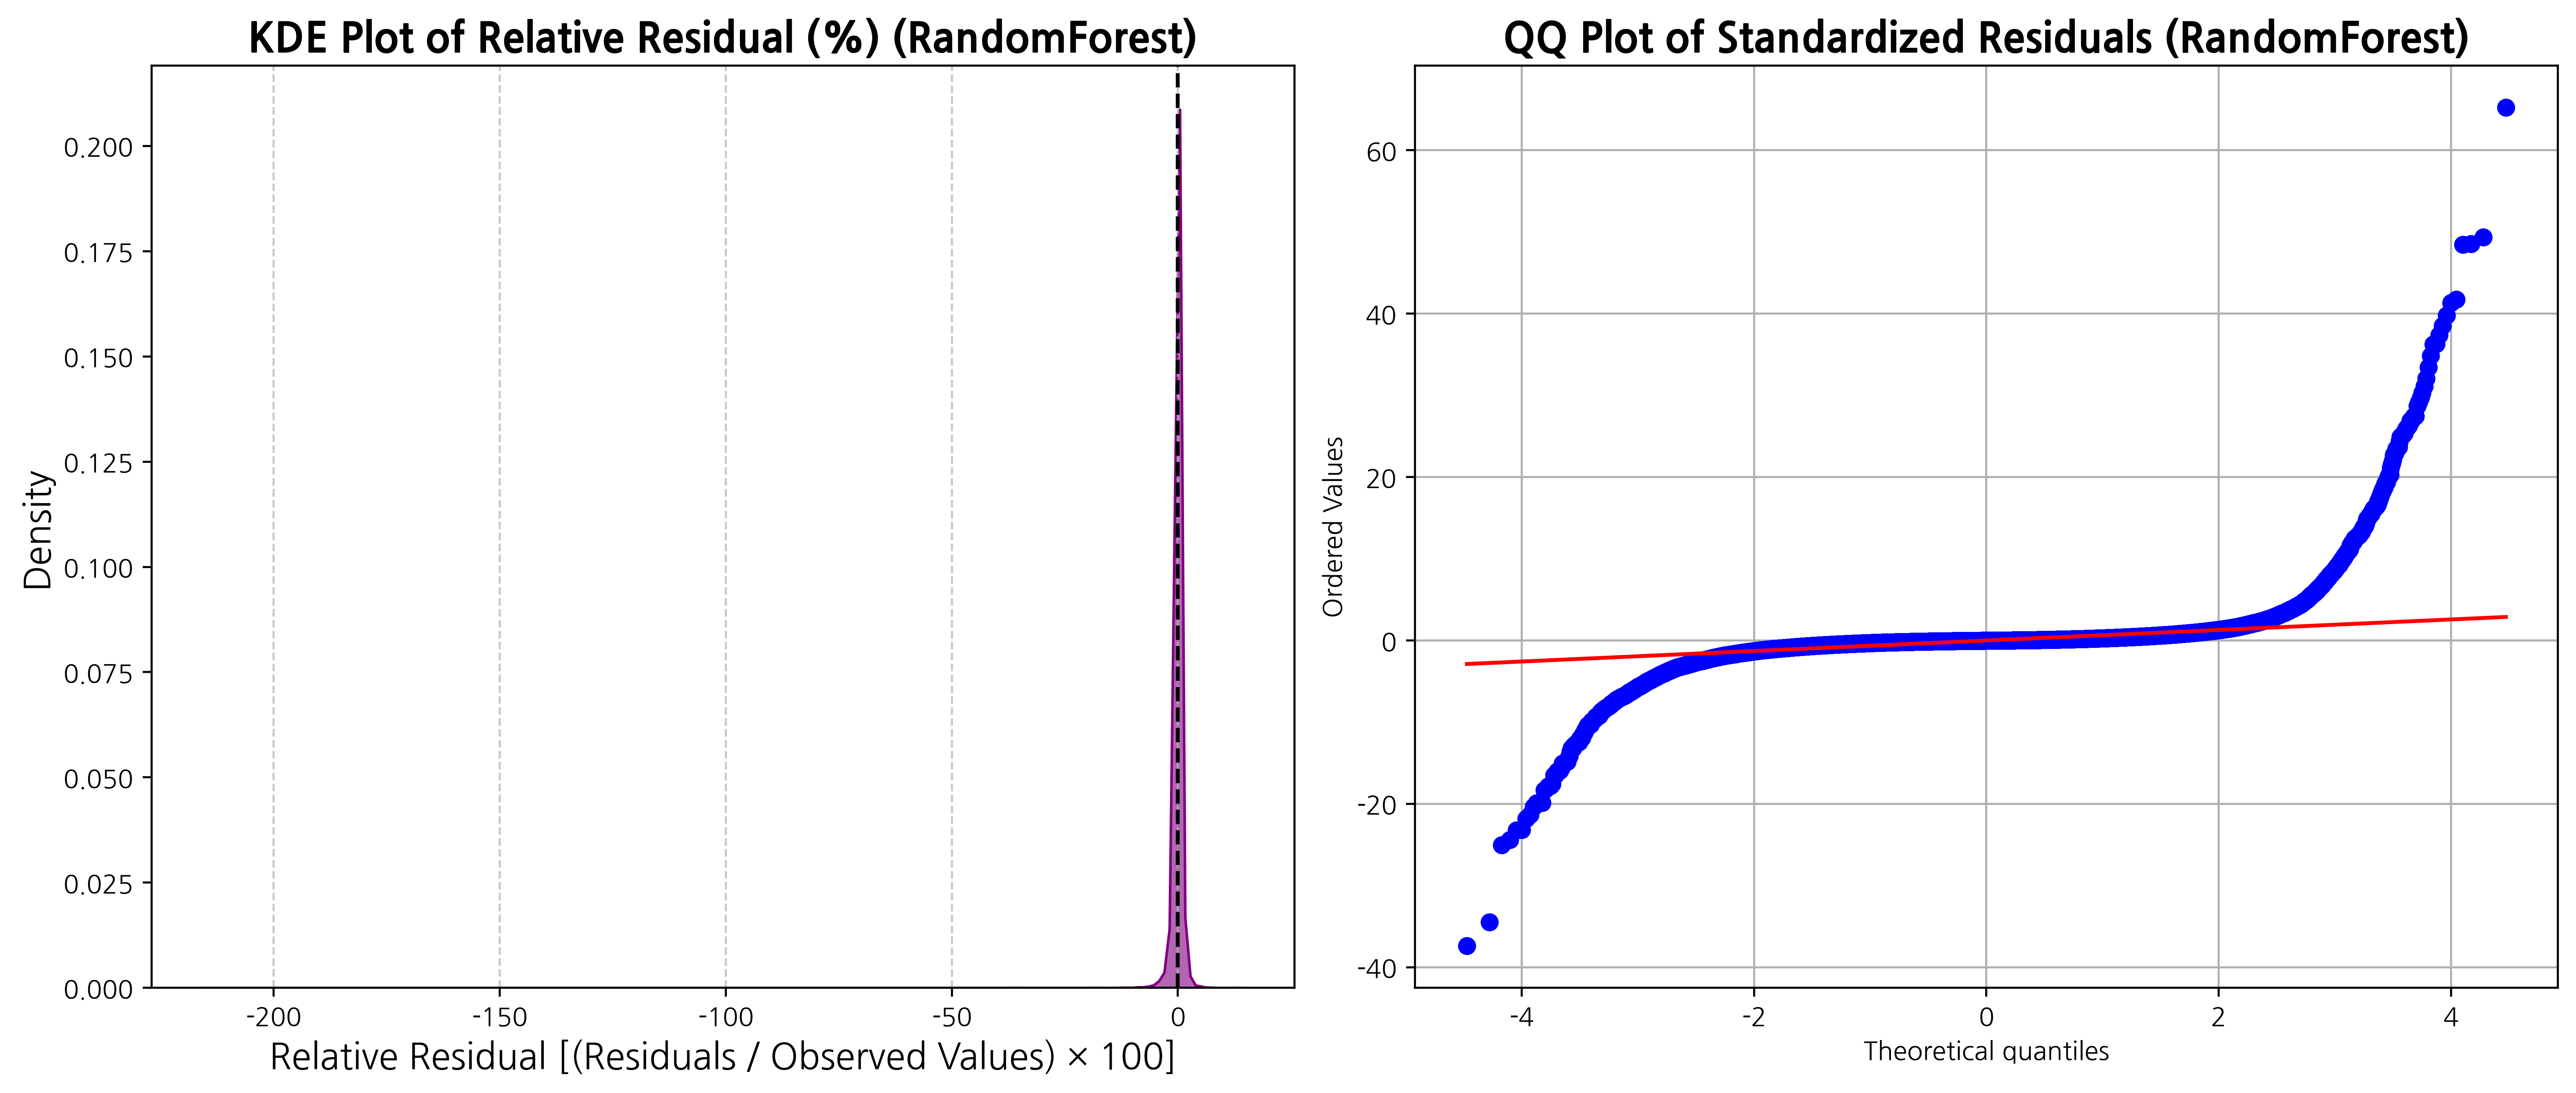

In [13]:
# ✅ 랜덤포레스트 1번째 모델 결과 분석 (고화질)
residual_ratio_rf_1 = analyze_residual_distribution("RandomForest", y_test, y_pred_rf, dpi=500)

# residual_ratio_rf_2 = analyze_residual_distribution("RandomForest2", y_test, y_pred_rf_2, dpi=500)

# residual_ratio_rf_3 = analyze_residual_distribution("RandomForest3", y_test, y_pred_rf_3, dpi=500)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals_scatter(residuals, feature_values, feature_name, model_name):
    """
    특정 Feature에 따른 잔차의 산점도(Scatter Plot)를 시각화하는 함수.

    Parameters:
    - residuals: 모델의 잔차 값 (y_test - y_pred)
    - feature_values: 특정 Feature의 값 (예: 단지 클러스터, 면적 등)
    - feature_name: Feature 이름 (문자열, 그래프 제목용)
    - model_name: 모델 이름 (문자열, 그래프 제목용)

    Returns:
    - 시각화된 산점도 그래프
    """
    plt.figure(figsize=(12, 6), dpi=300)

    # ✅ 산점도 플롯
    sns.scatterplot(x=feature_values, y=residuals, color="red", alpha=0.6, edgecolor="black")
    plt.axhline(0, color="black", linestyle="--")  # 기준선 추가
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel("Absolute Residuals", fontsize=12)
    plt.title(f"Absolute residuals (%) Scatter Plot by {feature_name} ({model_name})", fontsize=14, fontweight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.show()

# ✅ 사용 예제
# plot_residuals_scatter(residuals, X_test["단지클러스터"], "단지 클러스터", "RandomForest")
# plot_residuals_scatter(residuals, X_test["전용면적m"], "전용면적 (㎡)", "RandomForest")

In [15]:
residuals = abs(y_test - y_pred_rf)
residual_ratio = (residuals / (y_test+ 100)) * 100  # 퍼센트 변환


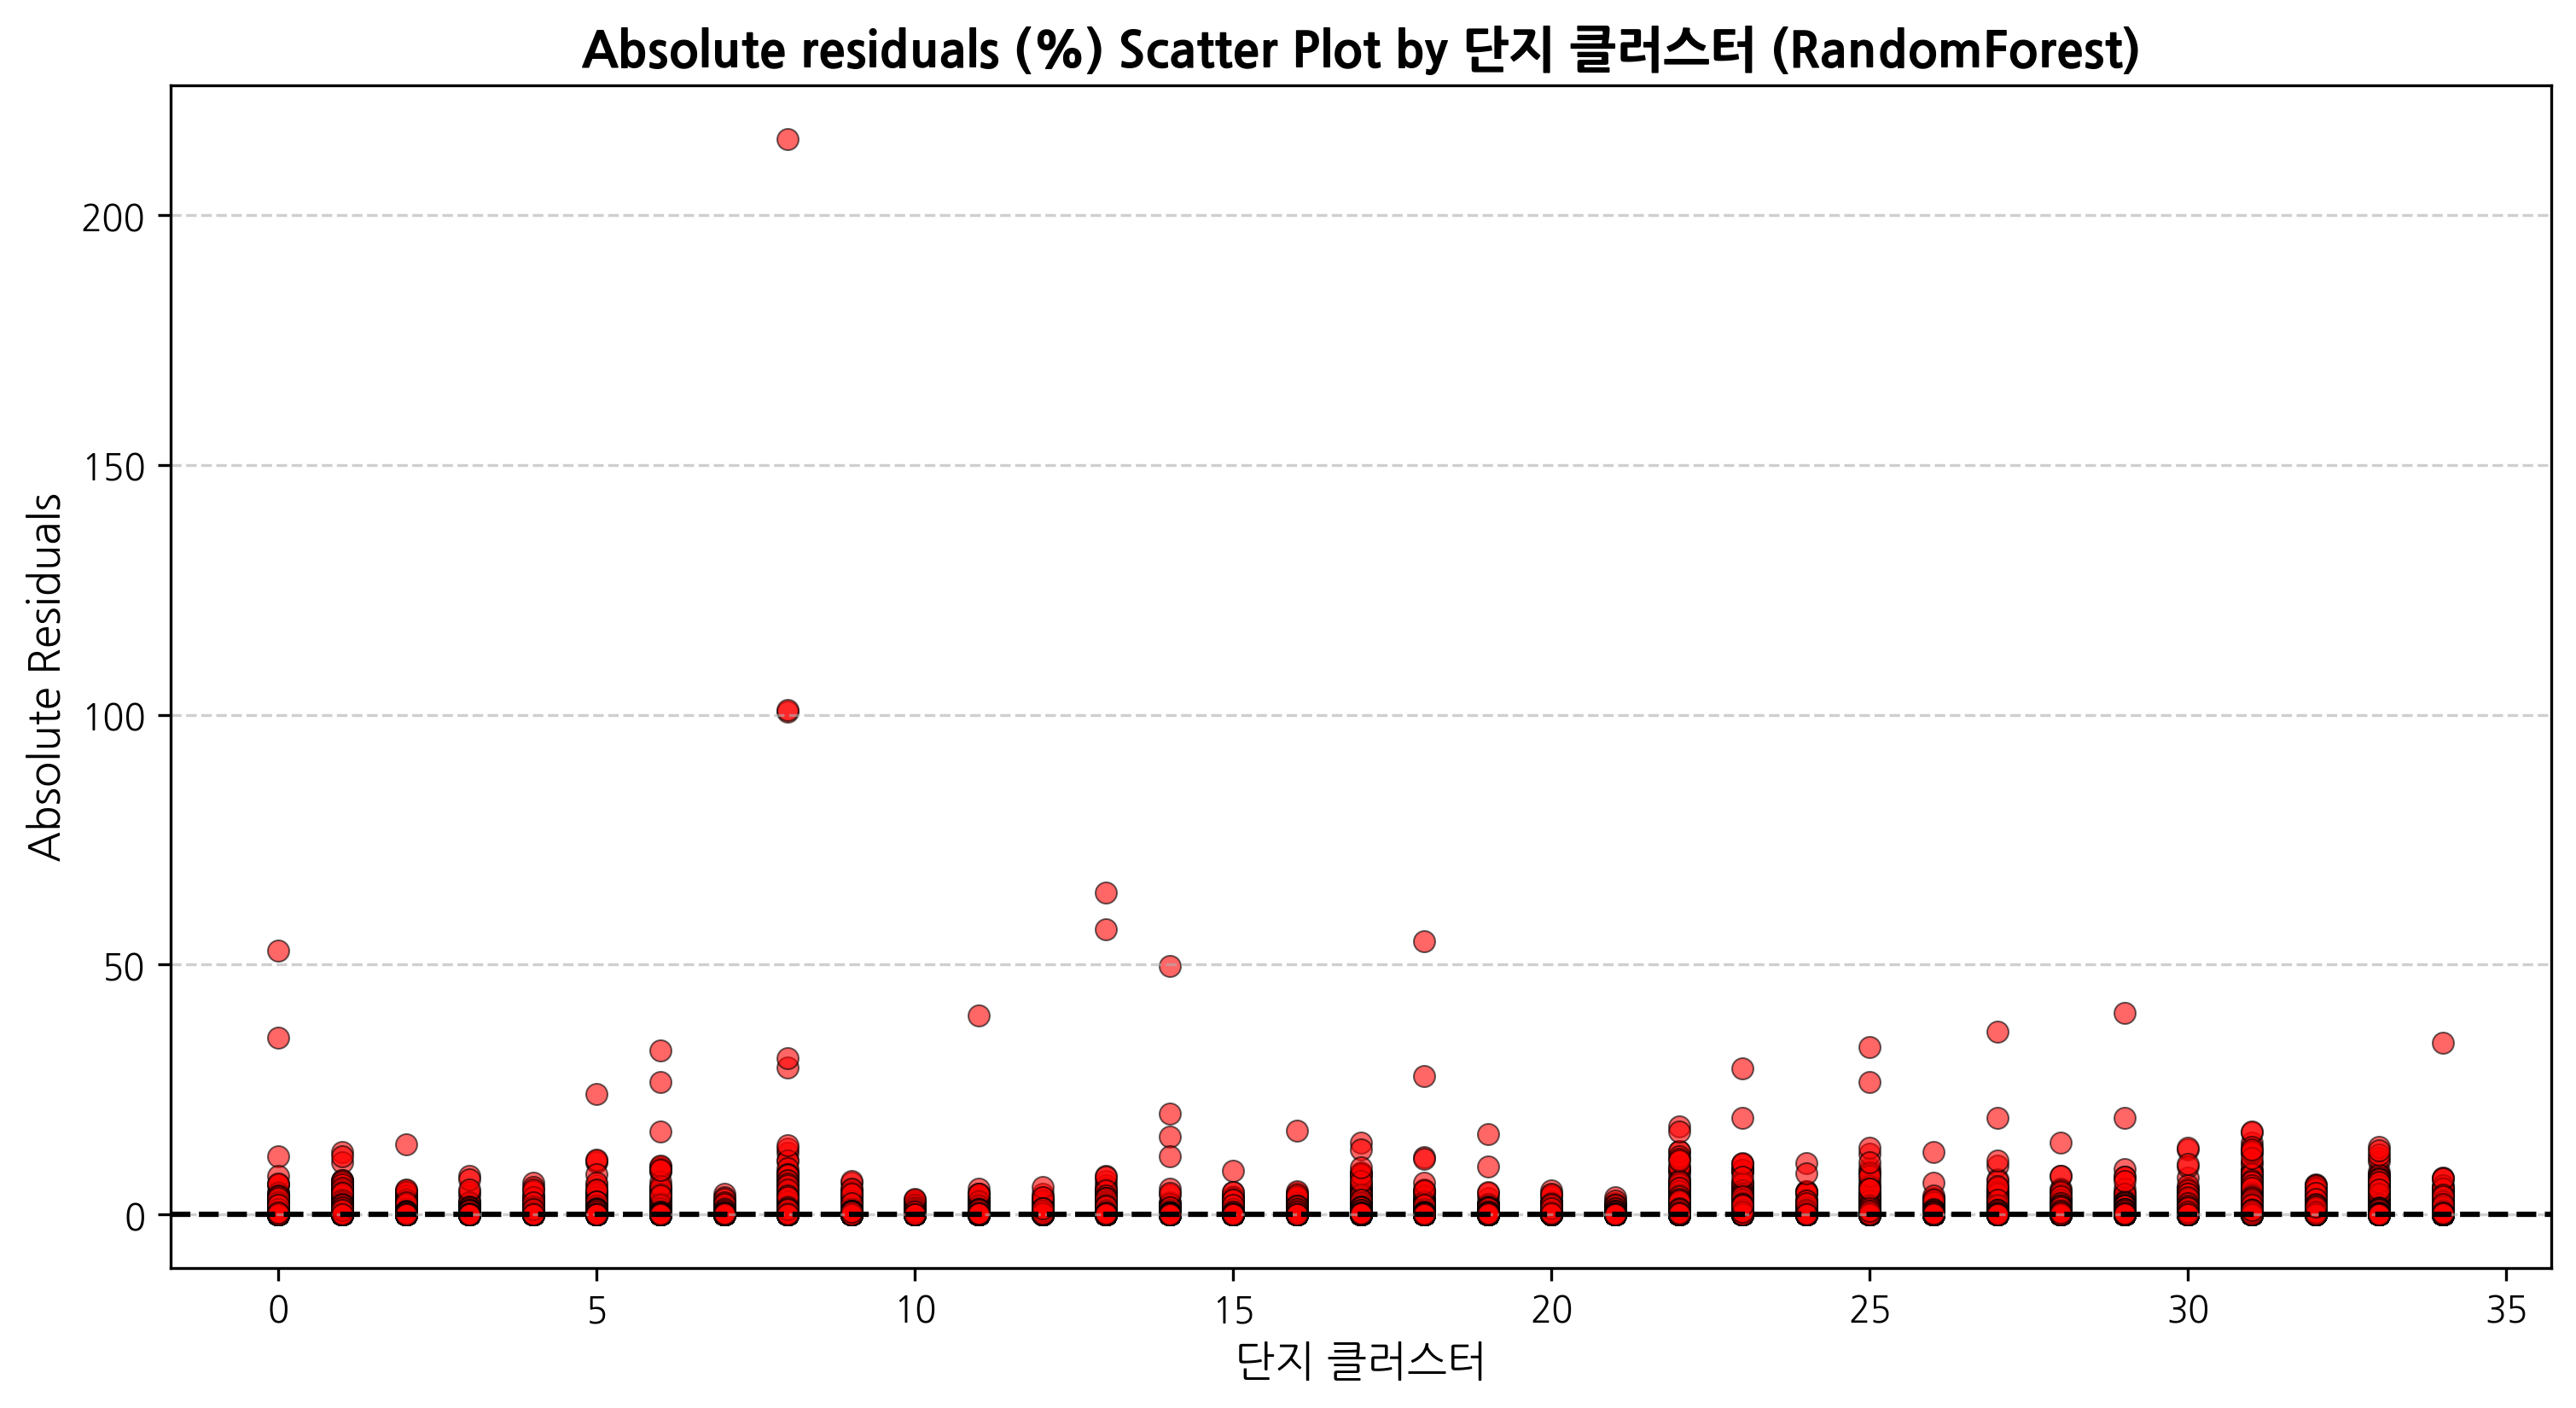

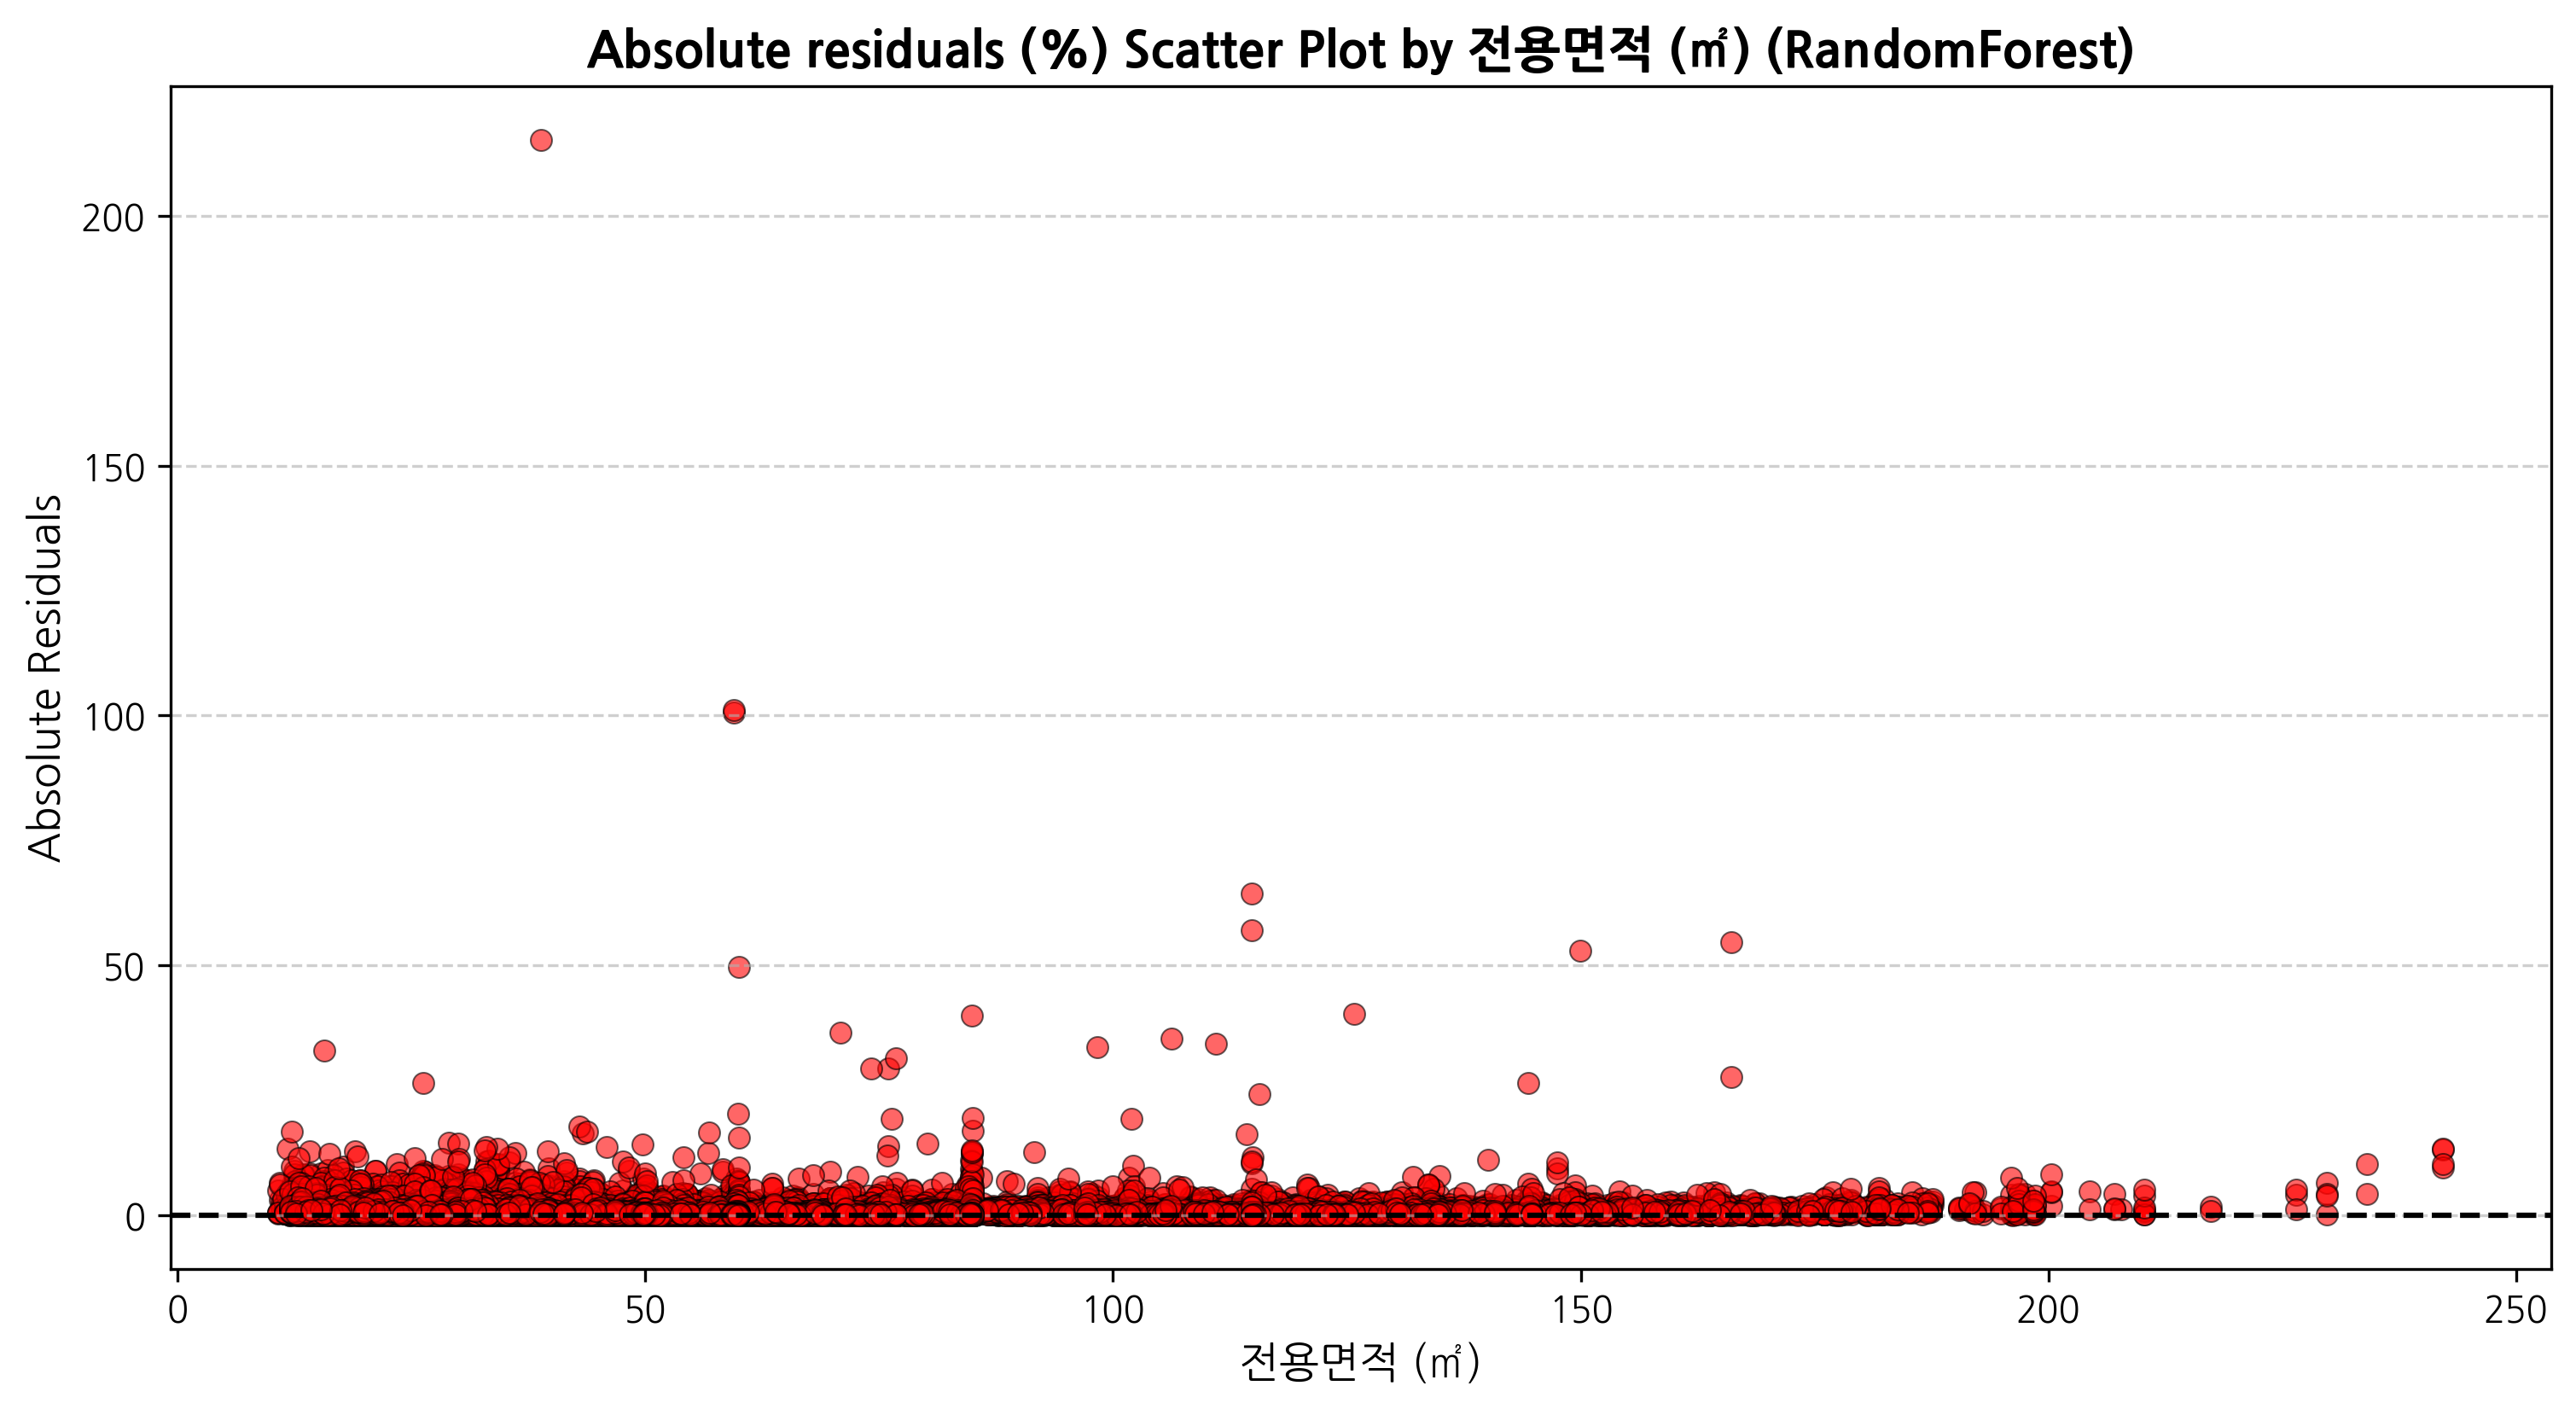

In [16]:
# ✅ 사용 예제
plot_residuals_scatter(residual_ratio, X_test["클러스터"], "단지 클러스터", "RandomForest")
plot_residuals_scatter(residual_ratio, X_test["전용면적m"], "전용면적 (㎡)", "RandomForest")

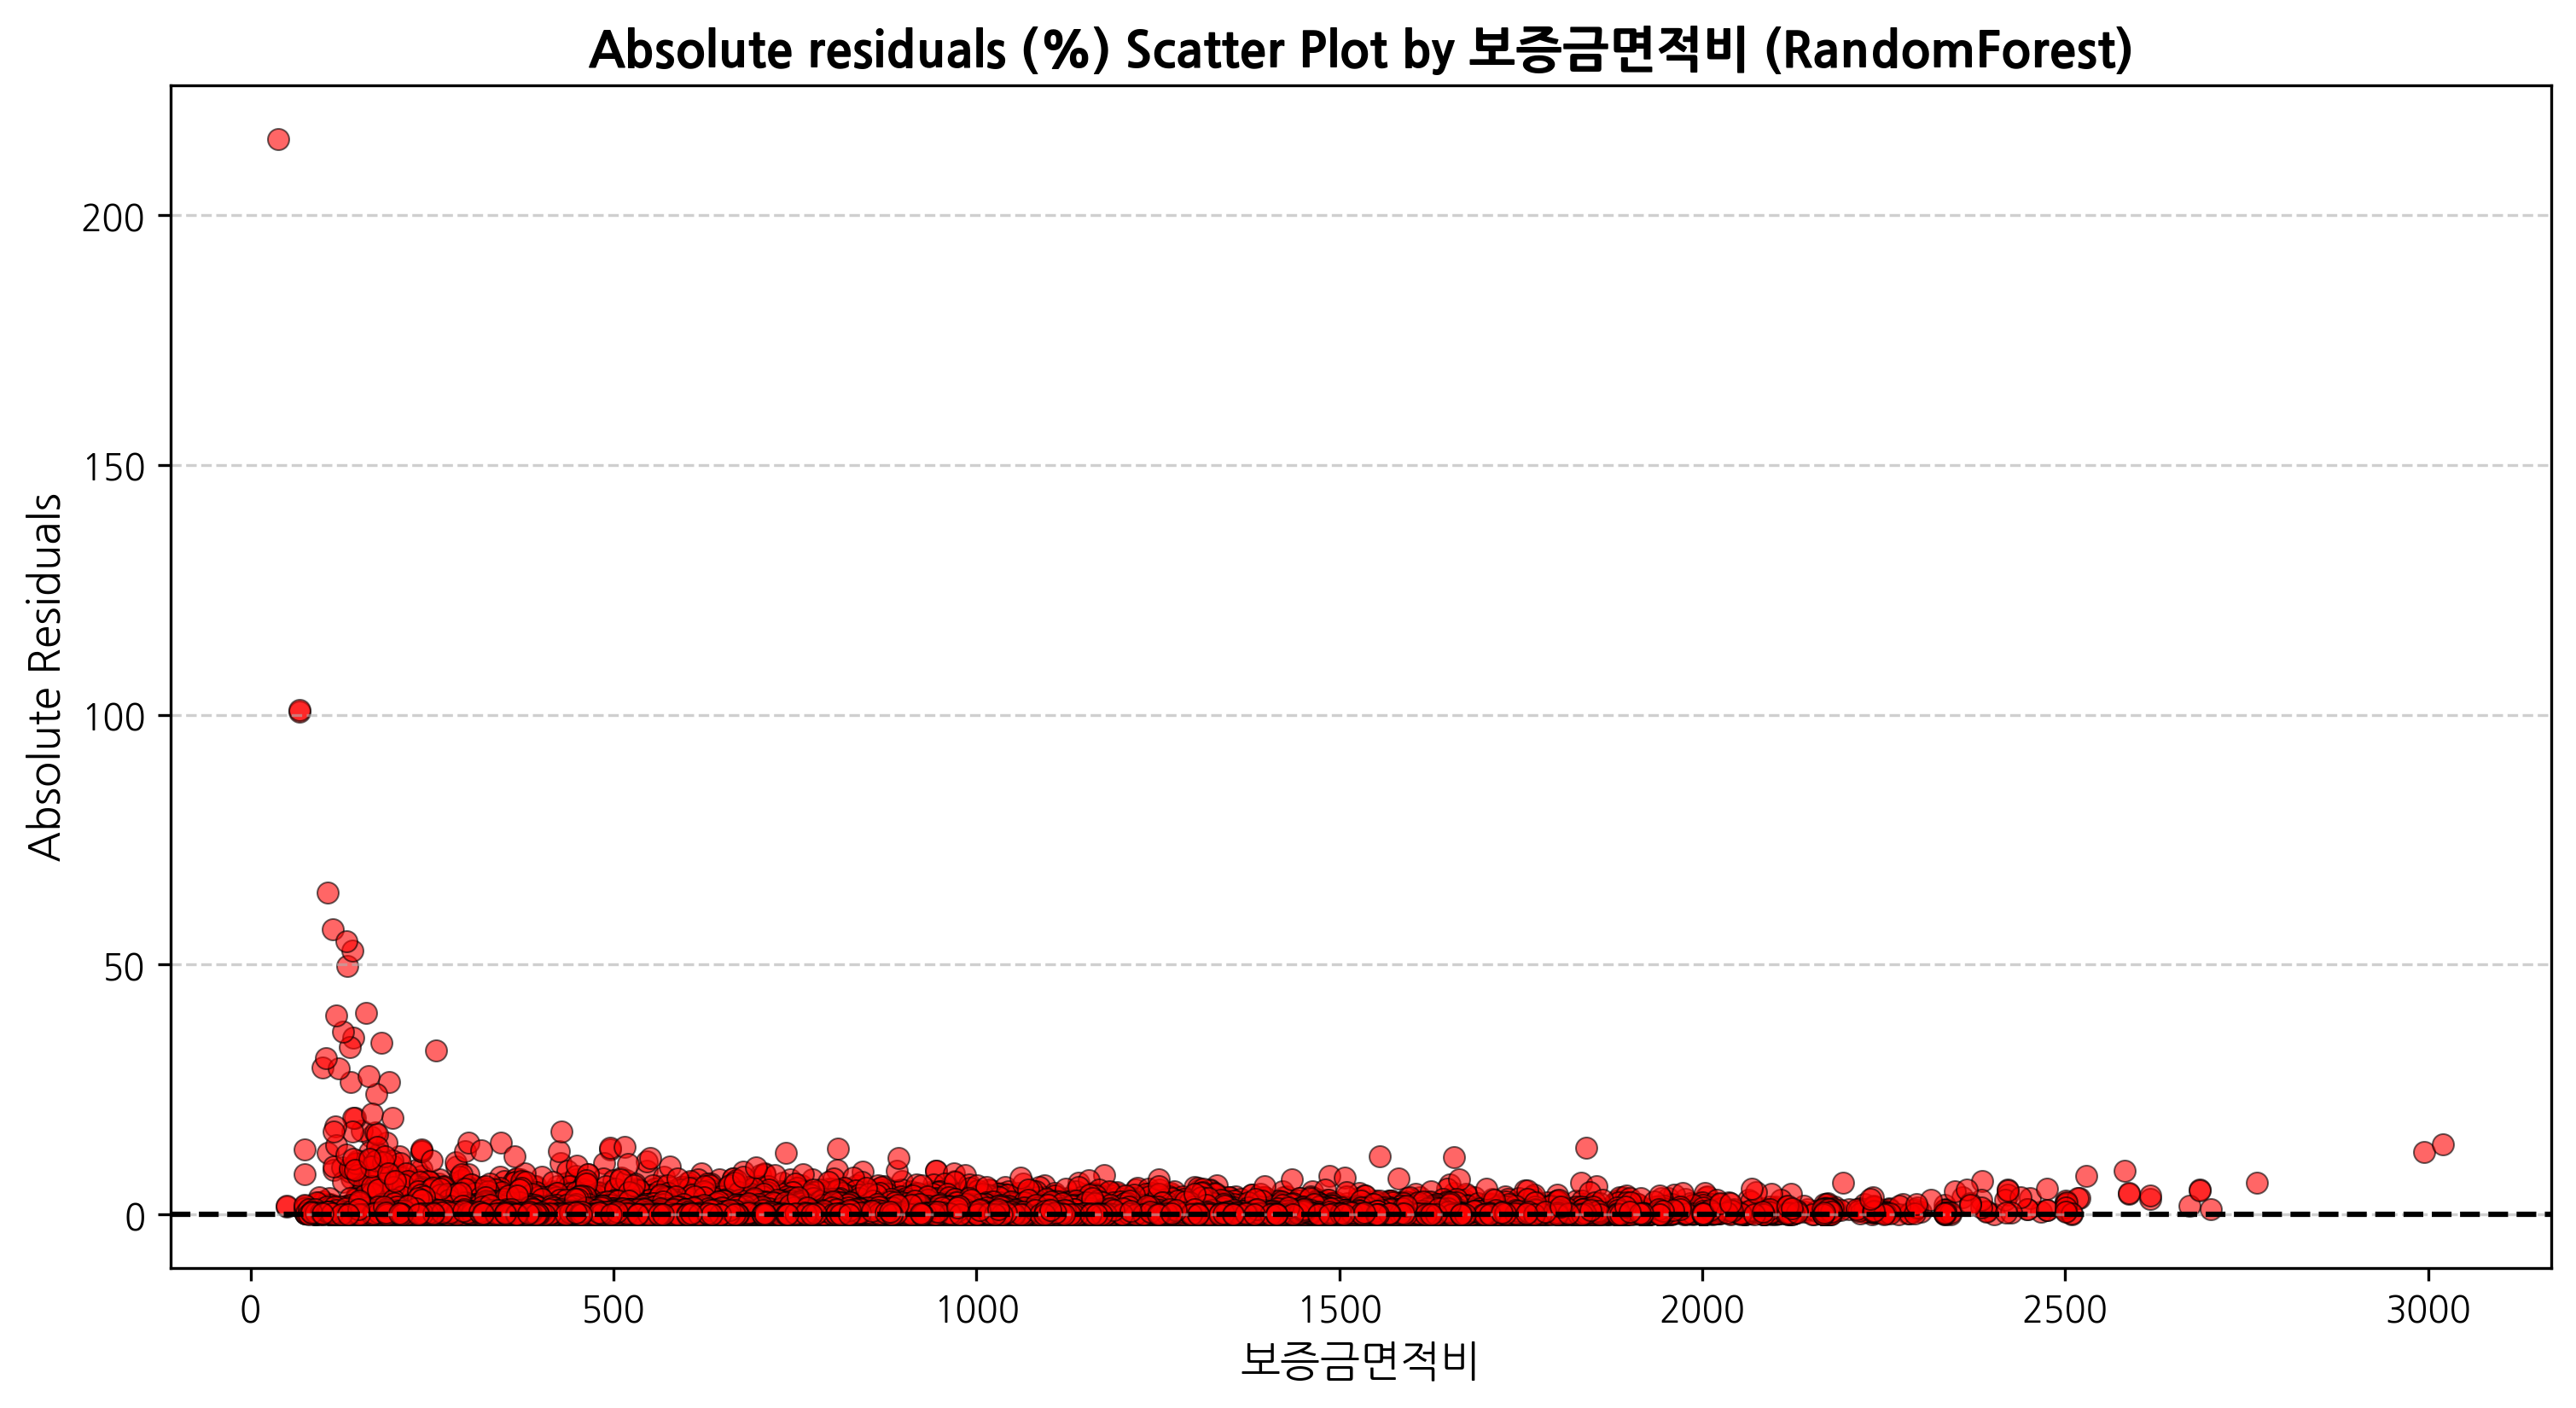

In [17]:
plot_residuals_scatter(residual_ratio, X_test["보증금면적비"], "보증금면적비", "RandomForest")

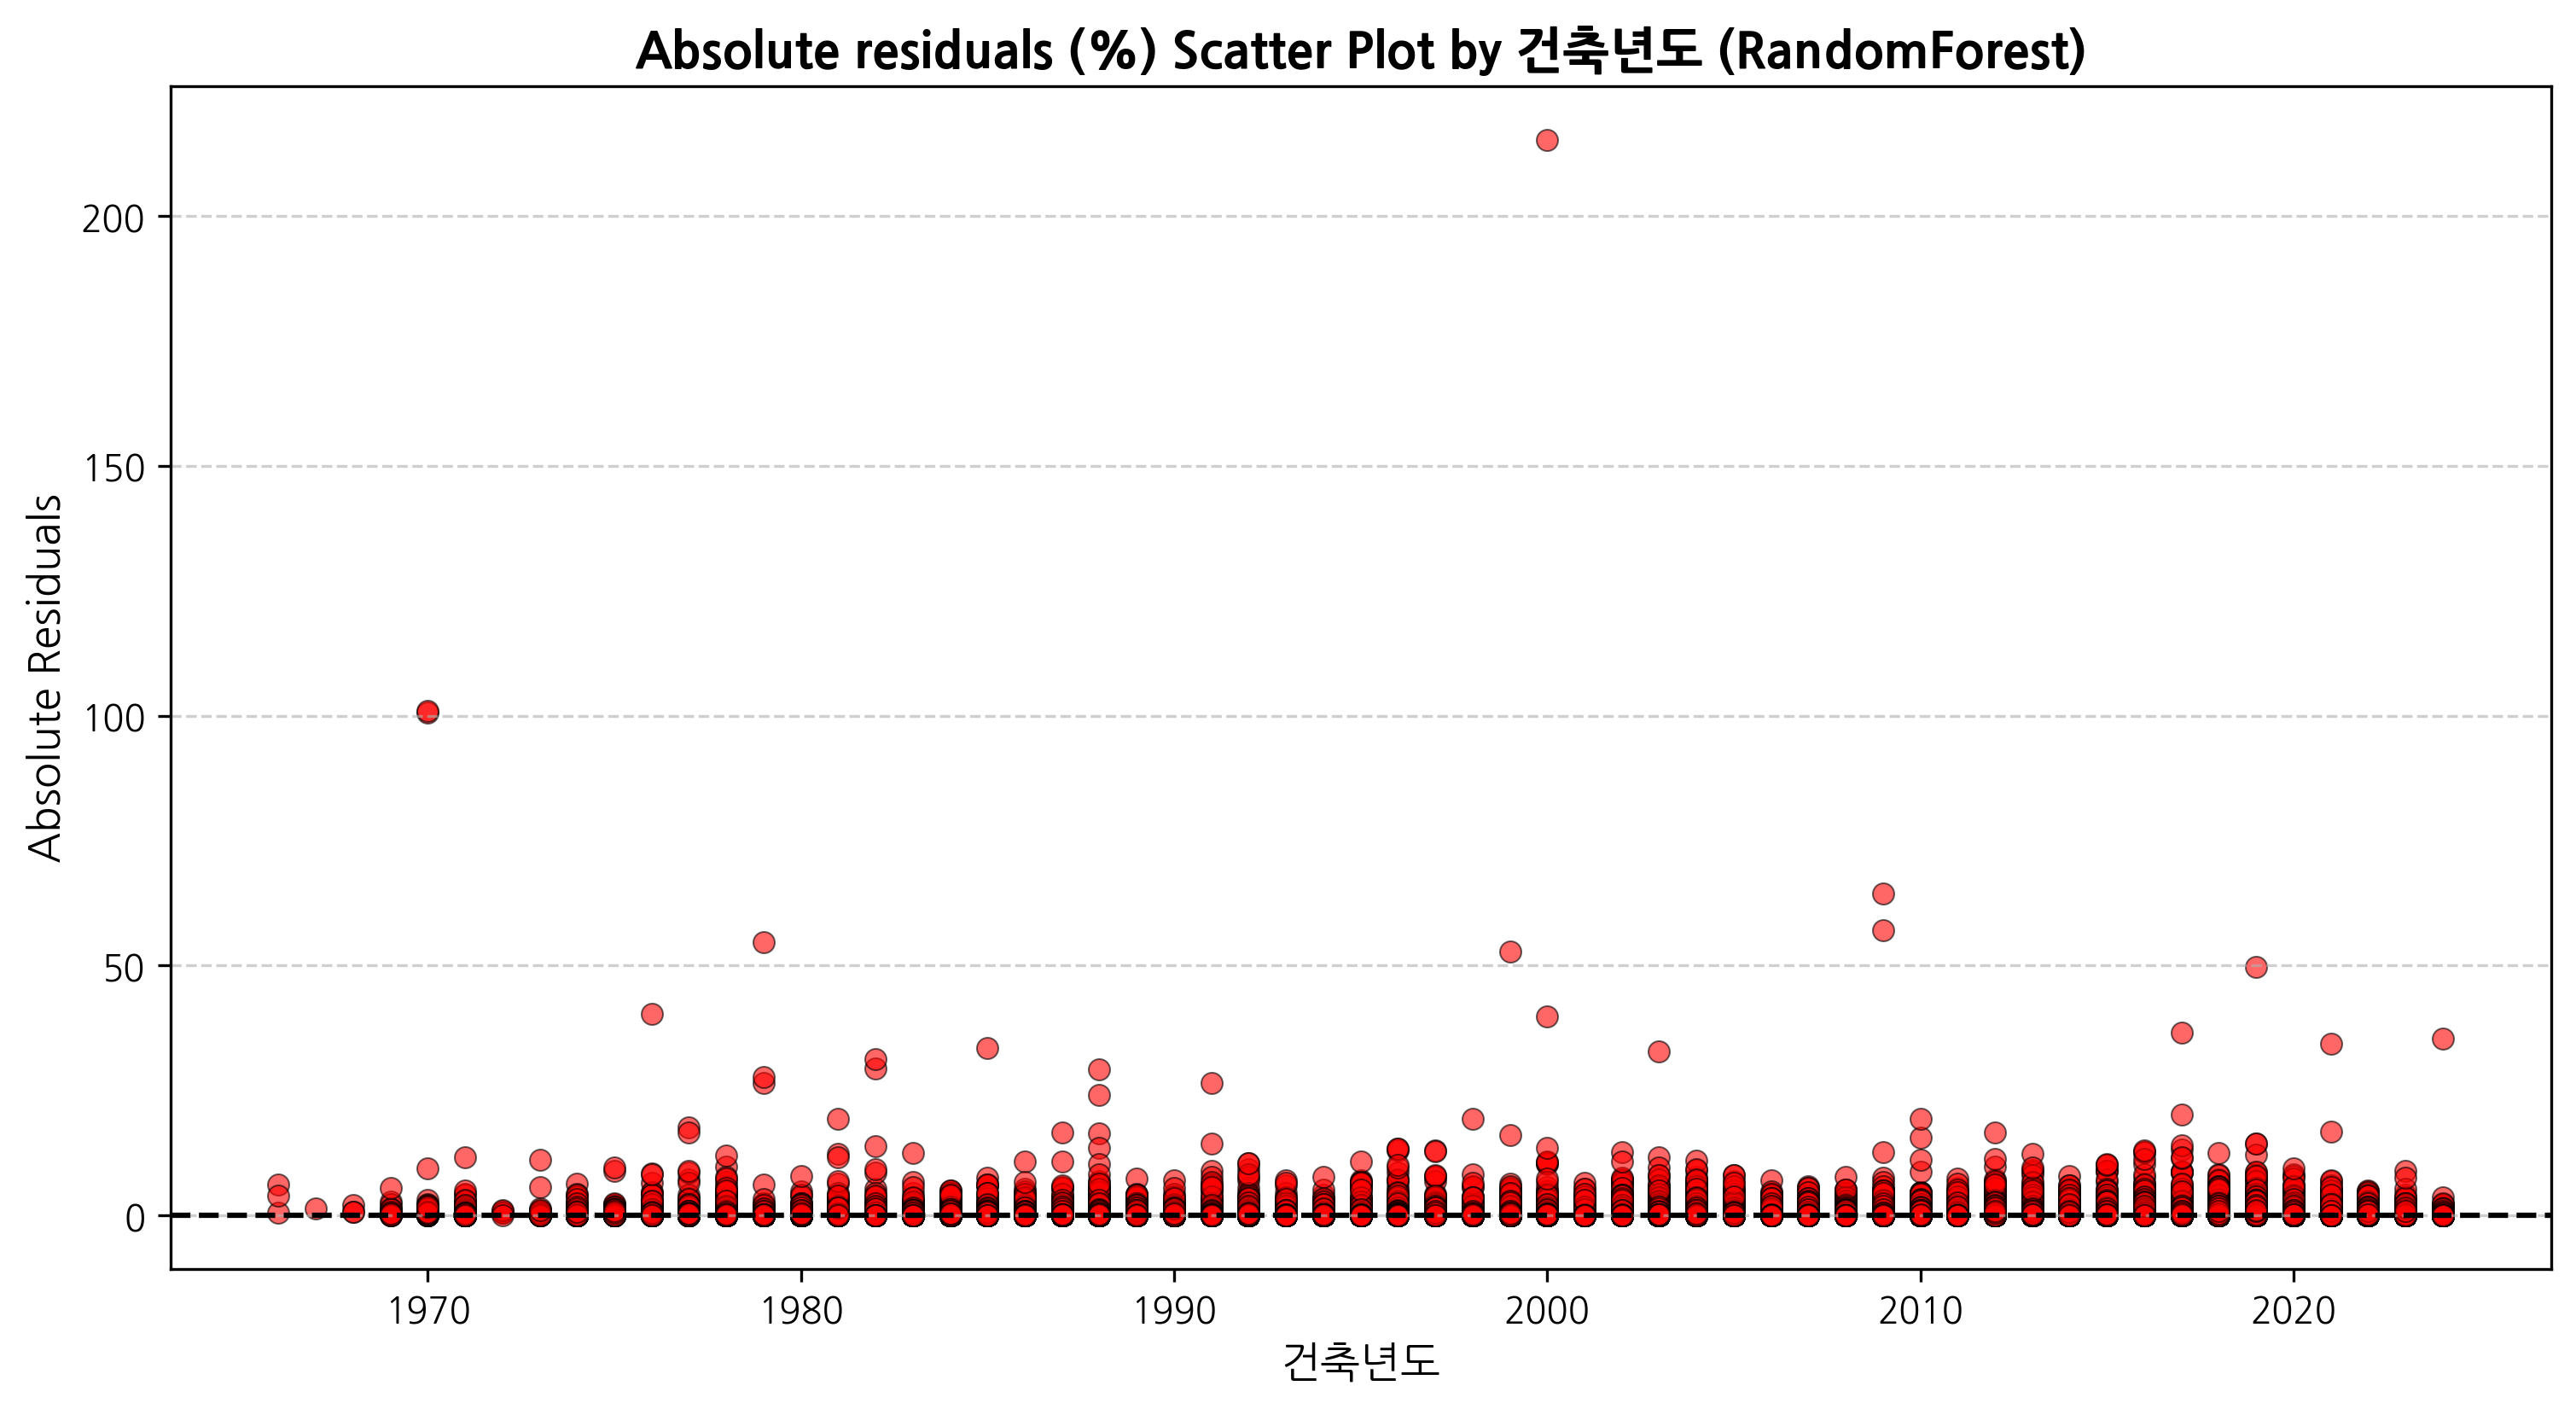

In [18]:

plot_residuals_scatter(residual_ratio, X_test["건축년도"], "건축년도", "RandomForest")

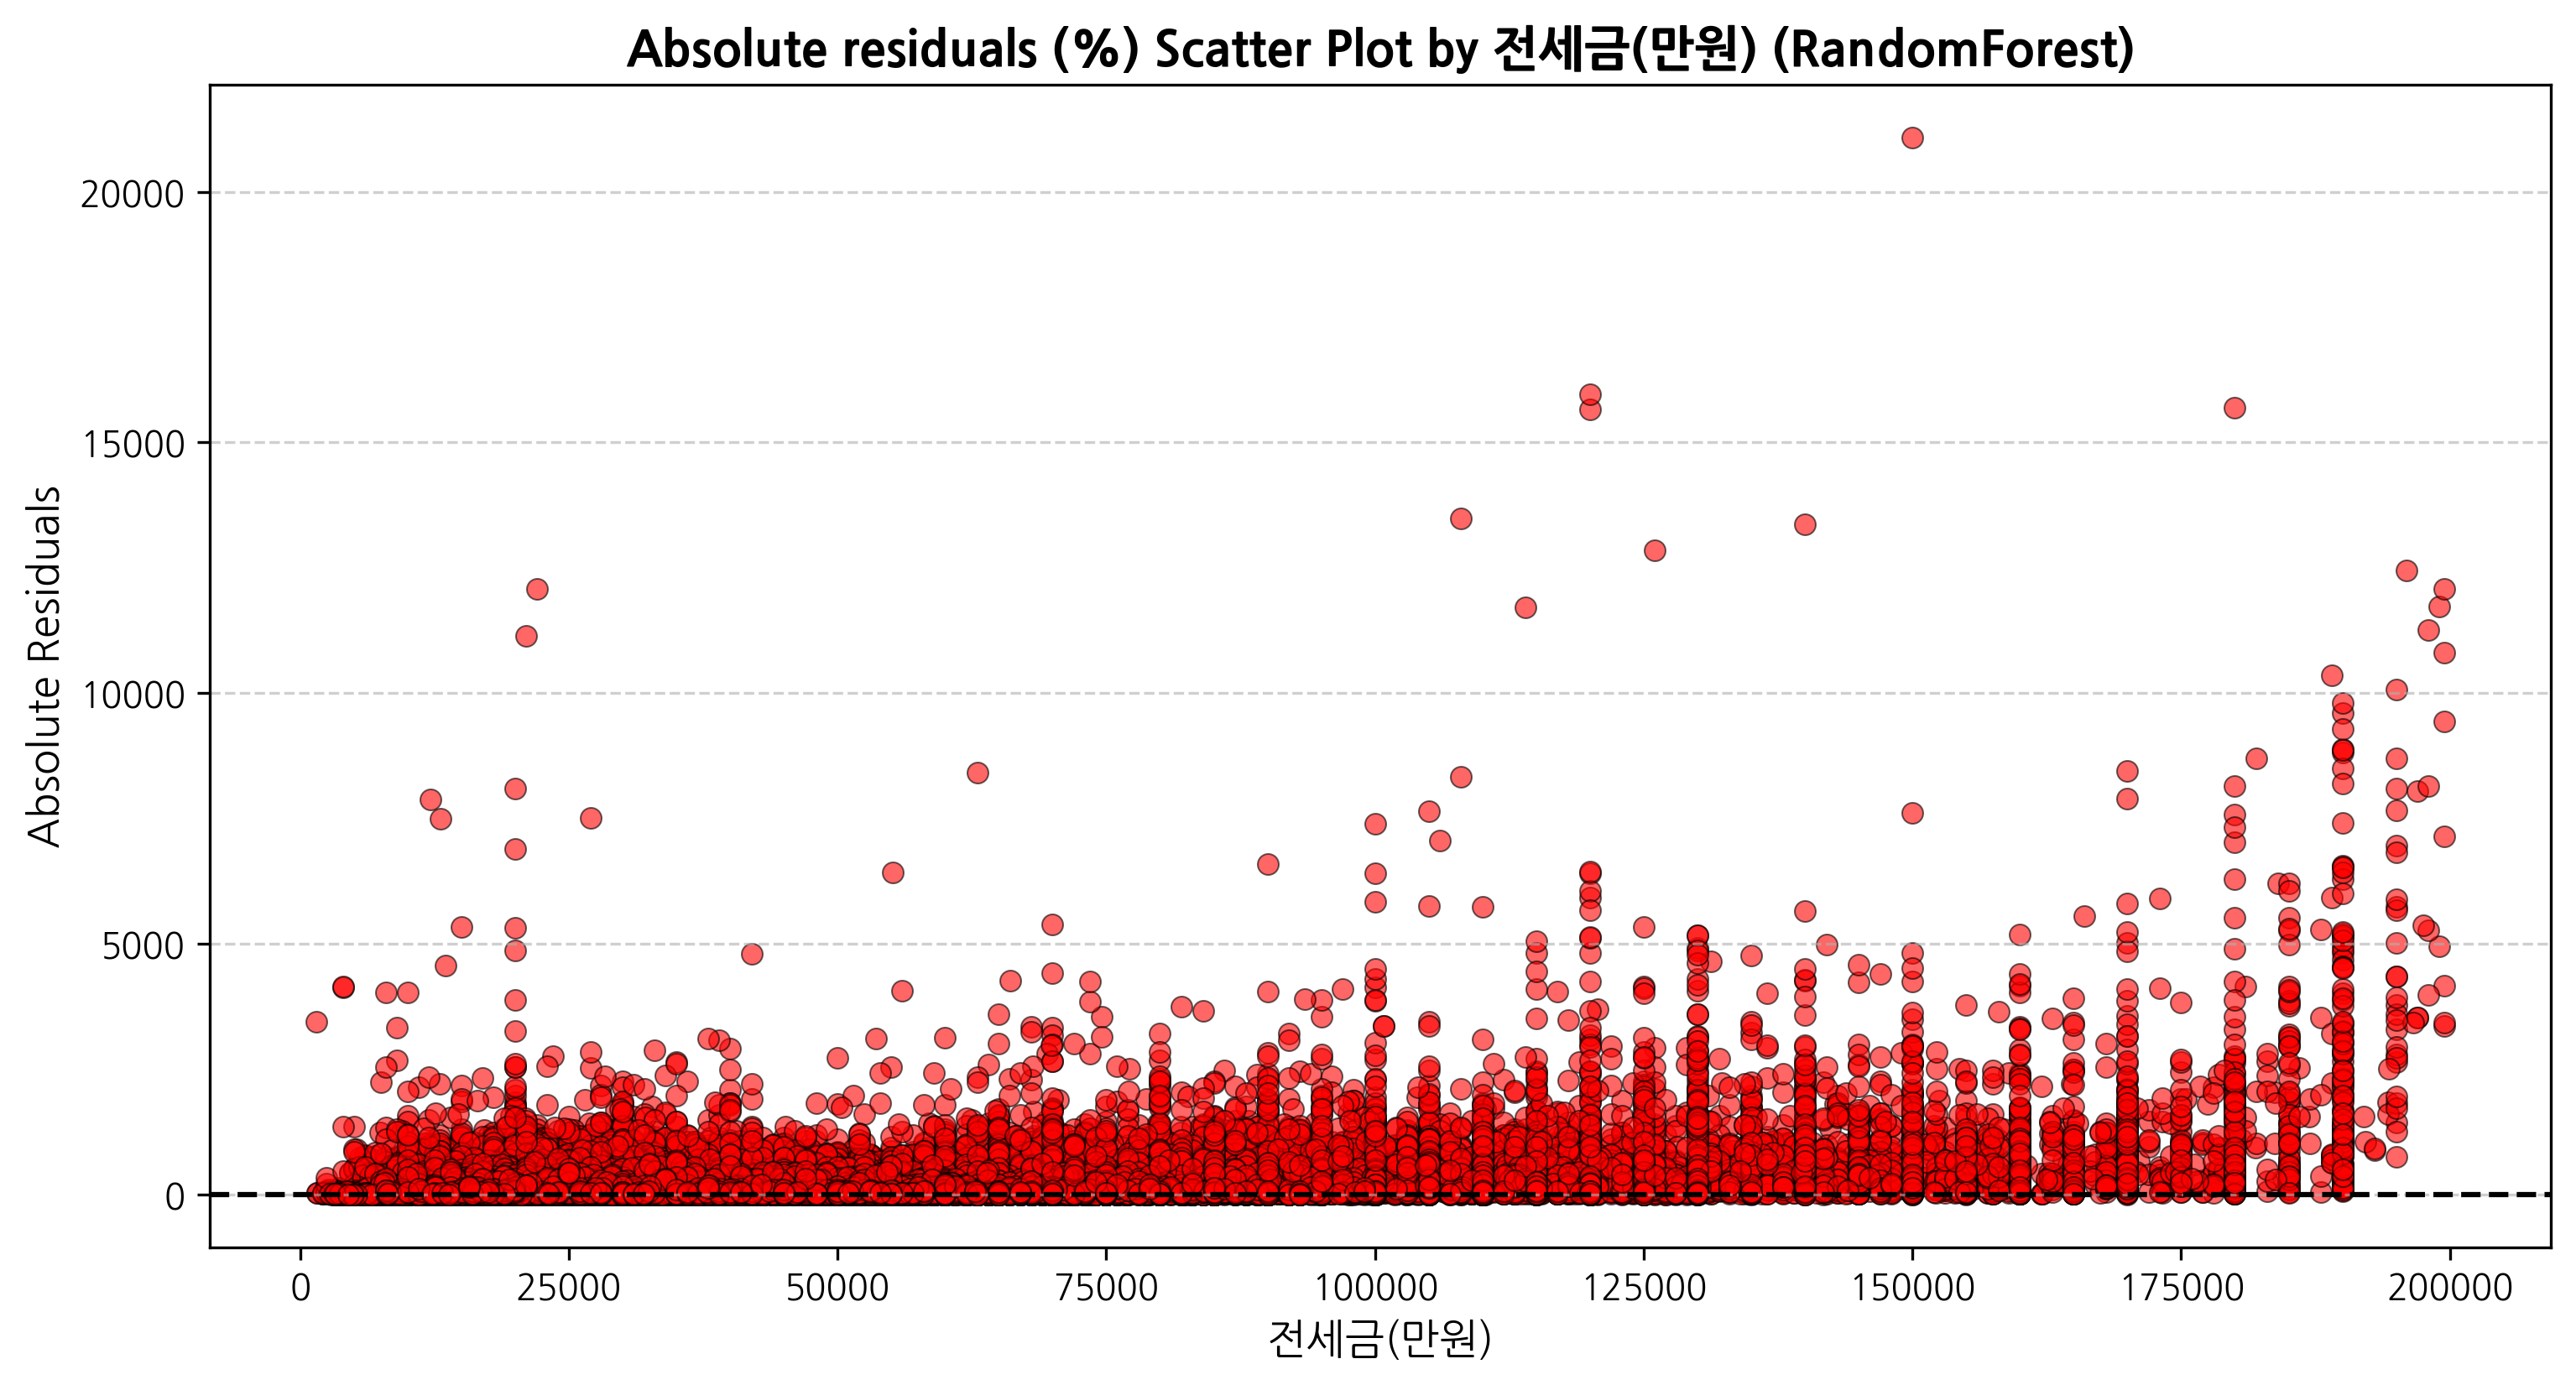

In [19]:
plot_residuals_scatter(residuals, y_test, "전세금(만원)", "RandomForest")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898053 entries, 0 to 898052
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   보증금만원            898053 non-null  float64
 1   계약분기             898053 non-null  int64  
 2   건축년도             898053 non-null  int64  
 3   계약연도             898053 non-null  int64  
 4   계약개월수            898053 non-null  int64  
 5   층                898053 non-null  int64  
 6   전용면적m            898053 non-null  float64
 7   계약구분보완(범주)       898053 non-null  int64  
 8   거래량              898053 non-null  int64  
 9   갱신요구권사용(2진)      898053 non-null  int64  
 10  종전계약유무(2진)       898053 non-null  int64  
 11  구_단지별_이상치만원(2진)  898053 non-null  int64  
 12  클러스터             898053 non-null  int64  
 13  지하철_거리(m)        892579 non-null  float64
 14  초등학교 거리(미터)      892579 non-null  float64
 15  Index            898053 non-null  float64
 16  Rate             898053 non-null  floa

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, feature_names, model_name):
    """
    랜덤포레스트 모델의 Feature Importance를 시각화하는 함수.

    Parameters:
    - model: 학습된 RandomForestRegressor 모델
    - feature_names: Feature 이름 리스트 (X_train.columns)
    - model_name: 모델 이름 (문자열, 그래프 제목용)

    Returns:
    - Feature Importance DataFrame 및 시각화 그래프 출력
    """
    # ✅ Feature 중요도 추출
    feature_importances = model.feature_importances_

    # ✅ DataFrame 생성
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # ✅ 시각화
    plt.figure(figsize=(12, 6), dpi=300)
    sns.barplot(y=importance_df['Feature'], x=importance_df['Importance'], palette="viridis")
    plt.xlabel("Feature Importance Score", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title(f"Feature Importance ({model_name})", fontsize=14, fontweight="bold")
    plt.gca().invert_yaxis()  # 중요도가 높은 순서로 정렬
    plt.grid(axis="x", linestyle="--", alpha=0.6)

    plt.show()

    return importance_df

# ✅ 사용 예제
# importance_df_rf = plot_feature_importance(rf_model, X_train.columns, "RandomForest")
# print(importance_df_rf.head(10))  # 상위 10개 Feature 출력

<ipython-input-20-c6eaaf7c0363>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=importance_df['Feature'], x=importance_df['Importance'], palette="viridis")


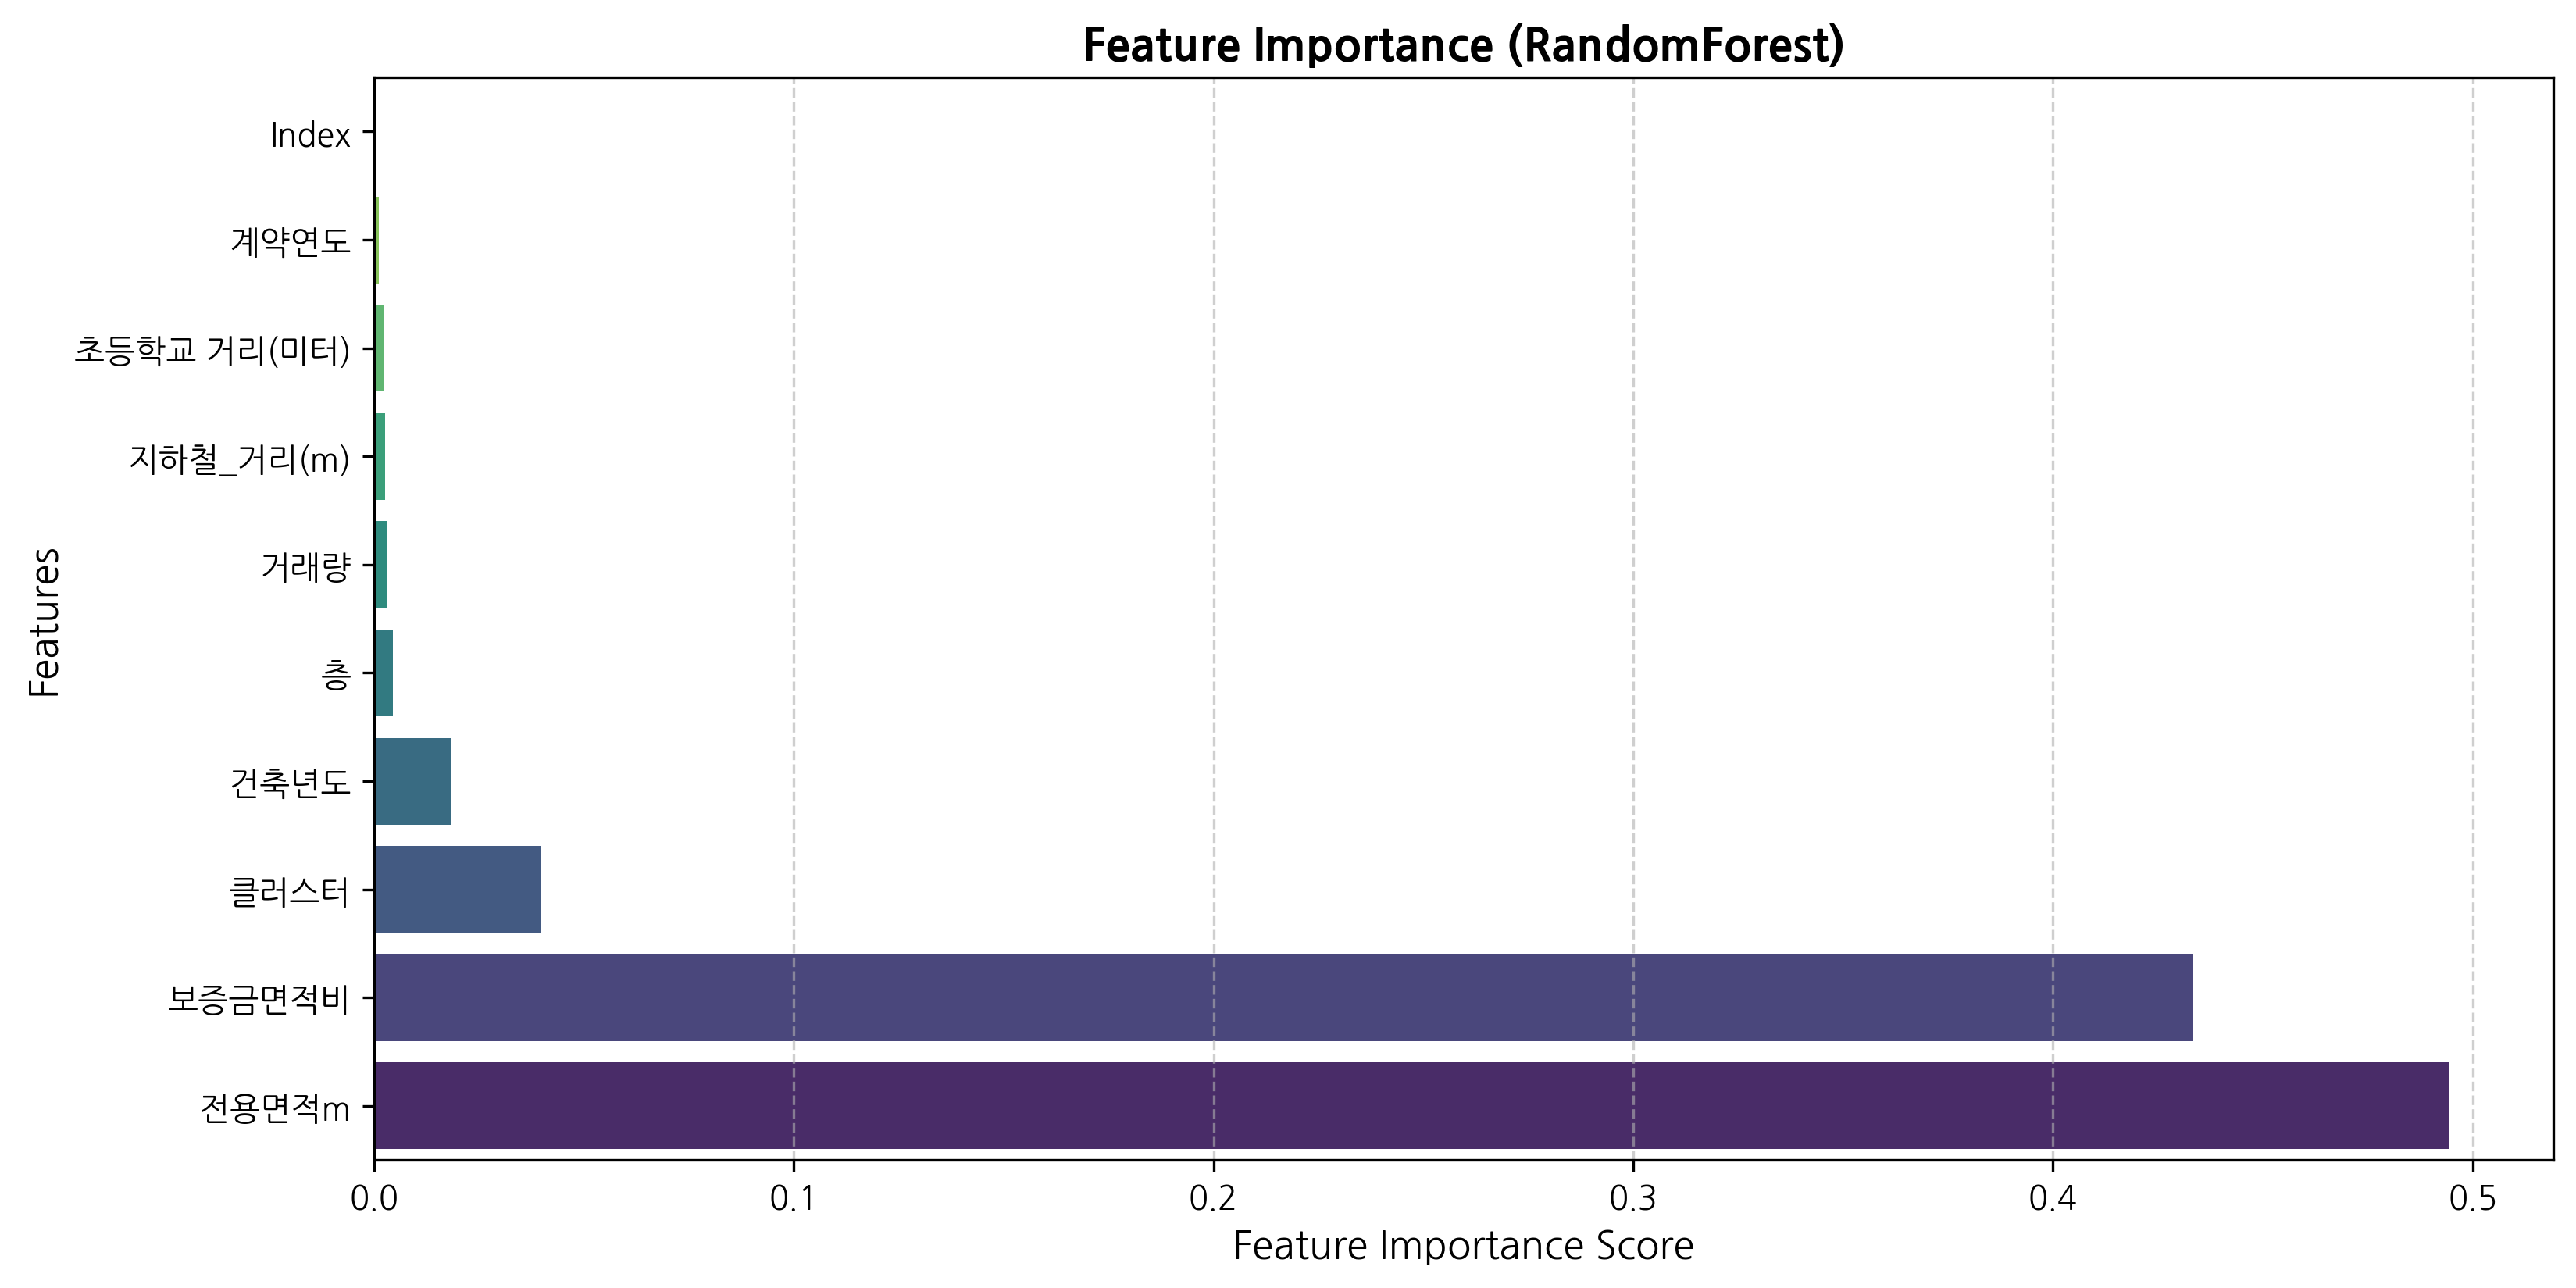

       Feature  Importance
0        전용면적m    0.494480
1       보증금면적비    0.433397
2         클러스터    0.039783
3         건축년도    0.018252
4            층    0.004542
5          거래량    0.003132
6    지하철_거리(m)    0.002634
7  초등학교 거리(미터)    0.002185
8         계약연도    0.001199
9        Index    0.000396


In [21]:
# ✅ 랜덤포레스트 Feature 중요도 분석
importance_df_rf = plot_feature_importance(rf_model, X_train.columns, "RandomForest")

# ✅ 상위 10개 Feature 출력
print(importance_df_rf.head(10))

In [22]:
li = residual_ratio[residual_ratio > 5].count()

In [23]:
print(f"5%를 초과한 예측 오차 갯수: {li}","\n5%를 초과한 예측 오차의 비율:", round(li/len(y_test),5) )

5%를 초과한 예측 오차 갯수: 369 
5%를 초과한 예측 오차의 비율: 0.00205
